<a href="https://colab.research.google.com/github/Praveen76/Image-Classification-with-Vision-Transformer/blob/main/ImageClassification_with_VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment, you will be able to:

* understand the vision transformer (ViT) model
* create sequences of image patches to feed to ViT
* perform image classification using ViT

## Problem Statement:
Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

## Architecture
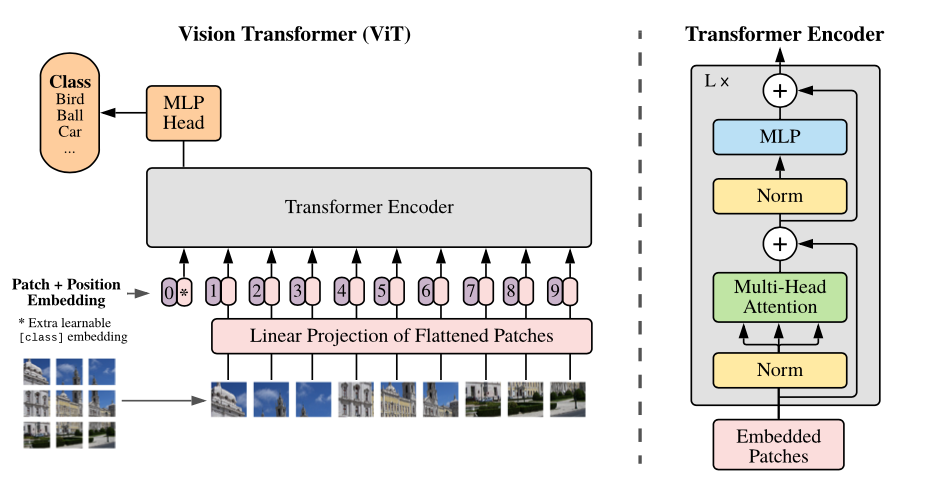

 The ViT employs the encoder part of the original Transformer architecture. The input to the encoder is a sequence of embedded image patches (including a learnable  class embedding prepended to the sequence), which is also augmented with positional information. A classification head attached to the output of the encoder receives the value of the learnable class embedding, to generate a classification output based on its state.

## Data Description

**CIFAR-100** is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 100 fine-grained classes that are grouped into 20 coarse-grained classes.

It has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
Here is the list of classes in the CIFAR-100:

<img src='https://cdn.iisc.talentsprint.com/AIandMLOps/Images/Cifar-100%20dataset.png' width=750px>

[Link](https://keras.io/api/datasets/cifar100/) to keras CIFAR100 small images classification dataset

### Setup Steps:

### Install necessary package

In [1]:
!pip -q install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.4 MB/s eta 0:00:00


### Importing required packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Prepare the data

In [3]:
num_classes = 100          # Number of classes
input_shape = (32, 32, 3)  # Input shape of the images

# Load the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

# Display the train and test images shapes
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

These hyperparameters will be used in model definition

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72       # We'll resize input images to this size
patch_size = 6        # Size of the patches to be extract from the input images i.e. 6x6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4

transformer_units = [              # Size of the transformer layers
    projection_dim * 2,
    projection_dim,
]

transformer_layers = 8
mlp_head_units = [2048, 1024]      # Size of the dense layers of the final classifier

## Use data augmentation

It is driven from original data with some minor changes. In the case of image augmentation, geometric and color space transformations such as (flipping, resizing, rotation, zoom) are made to increase the size and diversity of the training set.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),                       # A preprocessing layer which normalizes continuous features
        layers.Resizing(image_size, image_size),      # A preprocessing layer which resizes images
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization
data_augmentation.layers[0].adapt(x_train)

keras data augmentation [layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/)

Before patch creation, it's common practice to preprocess the image to ensure consistent dimensions and pixel values.

## Implement multilayer perceptron (MLP)

A function to implement DNN. These layers will be used to classify the images.

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

Divide the input image into a grid of non-overlapping patches. Each patch is a small square or rectangular region of the image. The choice of patch size can influence the trade-off between local and global information captured by the model.

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(                               # 'tf.image.extract_patches()' collects patches from the input image, as if applying a convolution
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],               # extracts patches of shape given by 'sizes'
            strides=[1, self.patch_size, self.patch_size, 1],             # which are 'strides' apart in the input image.
            rates=[1, 1, 1, 1],                                           # The output is subsampled using the 'rates' argument, in the same manner as "atrous" or "dilated" convolutions.
            padding="VALID",                                              # If VALID, only patches which are fully contained in the input image are included
        )
        patch_dims = patches.shape[-1]                                    # All extracted patches are stacked in the depth (last) dimension of the output
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

In [ ]:
plt.figure(figsize=(4, 4))

# Select a random image and show
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

# Create patches of the selected image
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

# Show pathes in a nice format
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable **position
embedding** to the projected vector.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via a
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data
    augmented = data_augmentation(inputs)
    # Create patches
    patches = Patches(patch_size)(augmented)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


In [ ]:
vit_classifier = create_vit_classifier()     # This function defines the ViT classifier
history = run_experiment(vit_classifier)     # This function compiles and trains the model and returns the log history

In [ ]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

Here, we have trained it for 10 epochs. We can try to train the model for more epochs since the performace is still improving.

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using the JFT-300M dataset, then fine-tuning it on the target dataset. **To improve the model quality** without pre-training, you can **try to train the model for more epochs, use a larger number of Transformer layers, resize the input images, change the patch size, or increase the projection dimensions**.
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, but also by parameters such as the learning rate schedule, optimizer, weight decay, etc. In practice, it's recommended to fine-tune a ViT model that was pre-trained using a large, high-resolution dataset.

### Reference:

[Image classification with Vision Transformer with Keras](https://keras.io/examples/vision/image_classification_with_vision_transformer/#image-classification-with-vision-transformer)